In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(xs):

    if not isinstance(xs, np.ndarray):
        return 3*math.sin(xs-2)
    
    ys = []
    for x in xs:
        ys.append(3*math.sin(x-2))
    return ys


In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

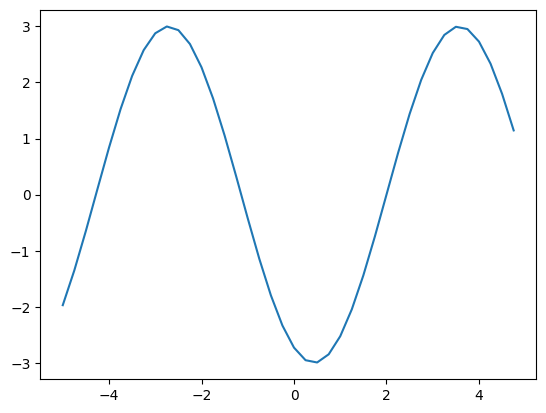

In [4]:
plt.plot(xs,ys)

In [5]:
# some derivative visualization stuff
h = 0.0000001
x = -3.0
(f(x + h) - f(x))/h

0.8509864102279607

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c 

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [ ]:

class Value:

    def __init__(self,data, _children=(), _op='', label = ''):
        self._backward = lambda: None
        self.grad = 0.0
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # repr used when we print object
    def __repr__(self):
        return f"Value(data={self.data})" 
    
    def __radd__(self, other):
        return self + other
    
    def __add__(self, other):

        # if other is a constant then we wrap it in Value obj
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + (-other)
    
    # wrapper for negation, we can simply avoid having to write
    # script for sub by using what we already have
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):

        # if other is constant we wrap it
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # python will try to default if __mul__ does not work
    def __rmul__(self, other): # other * self, case if we have 2 * Val obj
        return self * other
    

    def __truediv__(self, other): # divide 
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * ( self.data ** (other-1) ) * out.grad

        out._backward = _backward

        return out 

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        
        #builing topological graph for backprop,
        #we only append the parent node until all children are processed
        #this allows us to visit all nodes sequentially in reverse 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        self.grad = 1.0
        build_topo(self)


        for node in reversed(topo):
            node._backward()
        




In [9]:
a = Value(2.0)
b = Value(4.0)
a/b
#a * (1/b)
#a * (b**-1)
a-b


Value(data=-2.0)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f ; L.label = 'L'
L

Value(data=-8.0)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

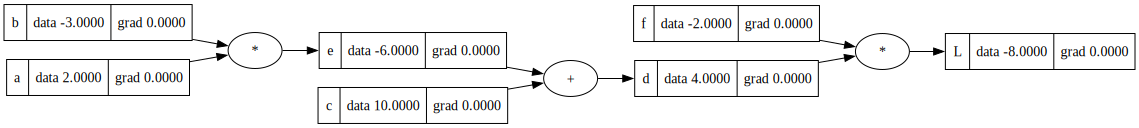

In [12]:
draw_dot(L)

In [13]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b;
d = e+c
L = d*f 

print(L.data)

-8.0


In [14]:
# want
# dL / da
# dL / db

# e = a*b

# dL/da = de/da dd/de dL/dd

#  =  -3 * 1.0 * -2 = 6

# dL/db  = 2.0 * 1.0 8 -2 = -4.0

In [15]:
a.grad = 6.0
b.grad = -4.0

In [16]:
# dL / dc
# dL/ de
# dd / dc = 1.0
# dd/ de = 1.0

# d = c + e

#Want
# dl / dc = dL / dd * dd / dc

#Know
#dL / dd
#dd / dc = 1.0


In [17]:
e.grad = -2.0 
c.grad = -2.0

In [18]:
# L = d*f
# dL/dd = f

In [19]:
f.grad = 4.0
d.grad = -2.0

In [20]:
# derivative of L with respect to L is 1
L.grad = 1.0

In [21]:
# limt def of derivative
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'

    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


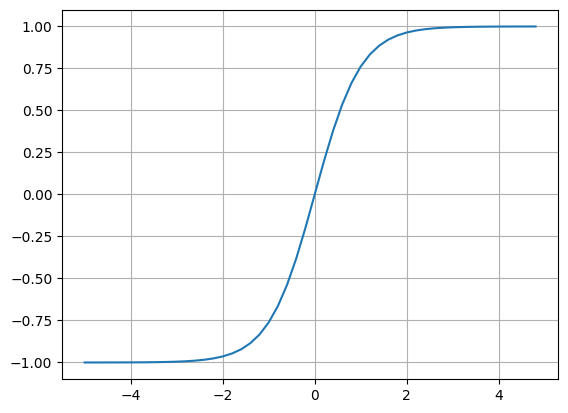

In [22]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [23]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



In [24]:
# even thought I have a backprop function for automation
# this is just for theoretrical / understanding backprop proccess

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad 
w1.grad = x1.data * x1w1.grad 
x1.grad = w1.data * x1w1.grad

# when we have a plus the backprop gradient simply flows through the next node
x1w1.grad = 0.5
x2w2.grad = 0.5


x1w1x2w2.grad = 0.5
b.grad = 0.5

n.grad = 1 - o.data**2

# o = tanh(n)
# do / dn = 1 - o**2

o.grad = 1.0

In [25]:
o.backward()

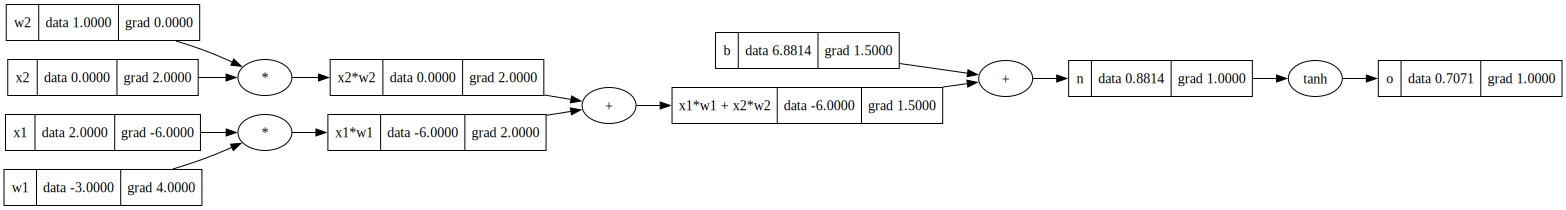

In [26]:
draw_dot(o)

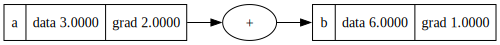

In [27]:
a = Value(3.0, label='a')
b  = a+a ; b.label ='b'
b.backward()
draw_dot(b)

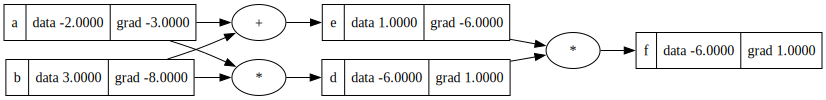

In [28]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [29]:
#continuing past visualization

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#-----
#o = n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
#-----

#instead of tanh we can use a different formula,
#we have impliment exponent and dividing methods so we can do this



o.label = 'o'

In [31]:
o.backward()

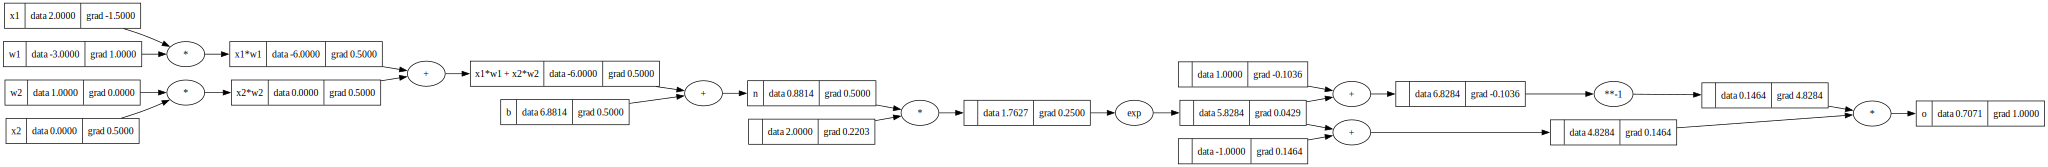

In [32]:
draw_dot(o)

In [33]:
import torch

In [34]:
# python defaults to float32 precision
# , setting to double here

# this demo in pytorch is doing what this project is emulating

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                                               
o = torch.tanh(n)                                ; o.retain_grad()      # not needed but added to show 1:1

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# our outputs are the exact same as the engine

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [35]:
x2.grad.item()

0.5000001283844369

In [36]:
import random as rd

In [54]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(rd.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(rd.uniform(-1,1))


  def __call__(self,x):
    # w * x + b

    # summing weights and adding bias
    # starting with self.b in the zip
    tot = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = tot.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    out = []
    for neuron in self.neurons:
      out.extend(neuron.parameters())
    return out
  
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    out = []
    for layer in self.layers:
      out.extend(layer.parameters())
    return out
    

In [120]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.2231448787681776)

In [121]:
n.parameters()

[Value(data=0.8237681884144799),
 Value(data=-0.7859058034246313),
 Value(data=-0.8858804874694068),
 Value(data=0.9980799124387734),
 Value(data=-0.27612092935822274),
 Value(data=0.6487580114927625),
 Value(data=0.8264867608220199),
 Value(data=-0.9201104156812157),
 Value(data=0.9472719076368039),
 Value(data=-0.1915906554180109),
 Value(data=-0.8274847648344197),
 Value(data=-0.3121887720945544),
 Value(data=-0.3249996181485262),
 Value(data=-0.8420936170602884),
 Value(data=-0.719692038078799),
 Value(data=-0.9914995207611164),
 Value(data=-0.7785996463350546),
 Value(data=0.3681141852467569),
 Value(data=0.43847936598421433),
 Value(data=0.2268595901761068),
 Value(data=-0.6664446615172153),
 Value(data=-0.9129945438783034),
 Value(data=-0.6756378943130057),
 Value(data=-0.4372130901182578),
 Value(data=0.5024096265340721),
 Value(data=-0.20092922952145087),
 Value(data=0.09999783207804391),
 Value(data=0.9769711933576319),
 Value(data=-0.822410936311825),
 Value(data=-0.53077763

In [ ]:
draw_dot(n(x))

In [122]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.2231448787681776),
 Value(data=-0.23343818996715215),
 Value(data=-0.49720460396217486),
 Value(data=-0.23533650081970986)]

In [123]:
losses = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
losses

Value(data=3.862559883591974)

In [124]:
losses.backward()

In [ ]:
draw_dot(losses) #  huge graph, forward passes with loss calculation

In [125]:
n.layers[0].neurons[0].w[0].grad

-0.0547444806676861

In [126]:
n.layers[0].neurons[0].w[0].data

0.8237681884144799

In [127]:
# gradient decent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [128]:
n.layers[0].neurons[0].w[0].data


0.8243156332211568

In [ ]:
# loss funtion decreased
ypred = [n(x) for x in xs]
newLoss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
newLoss

Value(data=4.804573900776477)

In [ ]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update - stochastic gradient descent
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.6054054884919715
1 3.3432791213642035
2 2.936856734534437
3 2.8328851921986877
4 2.7246088081307738
5 2.6231363687116716
6 2.4748791341700933
7 2.2953649180865012
8 2.0942883117818116
9 1.8619297370577592
10 1.5615549324439681
11 1.3352249208565354
12 1.1839873471163587
13 1.1382812507820026
14 0.3534158067976305
15 0.2079049675906991
16 0.1738269709196477
17 0.14954850680182324
18 0.13079286425591036
19 0.11579296037505449


In [130]:
ypred

[Value(data=0.8712792056680122),
 Value(data=-0.8100890132250884),
 Value(data=-0.809623195992081),
 Value(data=0.8359438904535819)]

In [176]:
#  more passes
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass, we need to reset to 0 since the gradients will stack if not
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.03 * p.grad
  
  print(k, loss.data)

0 0.0008711857780491068
1 0.0008707386218484307
2 0.0008702919092753672
3 0.0008698456396795472
4 0.0008693998124118176
5 0.0008689544268242791
6 0.0008685094822703382
7 0.0008680649781045949
8 0.0008676209136829261
9 0.0008671772883624532
10 0.0008667341015015214
11 0.0008662913524597565
12 0.0008658490405979597
13 0.0008654071652782209
14 0.0008649657258638418
15 0.0008645247217193401
16 0.0008640841522104656
17 0.0008636440167041935
18 0.0008632043145687042
19 0.0008627650451734302
20 0.0008623262078889559
21 0.0008618878020871489
22 0.0008614498271410122
23 0.0008610122824248049
24 0.0008605751673139683
25 0.000860138481185132
26 0.0008597022234161478
27 0.000859266393386019
28 0.0008588309904749983
29 0.0008583960140644721
30 0.0008579614635370249
31 0.0008575273382764338
32 0.0008570936376676465
33 0.0008566603610967889
34 0.0008562275079511776
35 0.0008557950776192536
36 0.0008553630694906665
37 0.0008549314829562193
38 0.0008545003174078654
39 0.0008540695722387363
40 0.0008536

In [177]:
ypred

[Value(data=0.9891583312294716),
 Value(data=-0.9850059553342193),
 Value(data=-0.9835869827715416),
 Value(data=0.9852615610625374)]